,Index,Slide Image,Extracted Text
0,1,,Drugs used in the pharmacotherapy of GIT disorders.J. Mojzis
1,2,,Peptic ulcerGastric mucosa -a sensitive balance of factors preventing self-digestionProtective factors- bicarbonate- mucus- blood supply- epithelial cell regenerationAggressive factors- HCl- pepsin- bile acids- H. pylori- ROS
2,3,,
3,4,,Peptic ulcer - cont.H. pyloriBile refluxStressProstaglandin synthesis inhibitorsGlucocorticoidsAlcoholSmokingBlood flow disturbancy
4,5,,Gastric ulcer in the antrum of the stomach with overlying clot.
5,6,,"Regulation of gastric acid secretiongastric acid is secreted by parietal cells and is controlled by:gastrinhistamineacetylcholine prostaglandins E2, I2"
6,7,,"Non-pharmacological therapy- sleep, stress- diet /avoid ""aggressive"" food, caffeine/ - smoking"
7,8,,"Drugs used to treat peptic ulcer1. Drugs used to diminish the effect of HCl- antisecretory drugs (PPI, H2-blockers, parasympatholytic)- antacids (aluminum hydroxide, magnesium hydroxide, calcium carbonate, sodiumbicarbonate)2. Cytoprotective agentsprostaglandinssucralfatecolloidal bismuth3. Anti-Helicobacter pylori drugs"
8,9,,Parietal cell
9,10,,"Proton-pump inhibitors (PPI)omeprazole, lansoprazole, pantoprazole ...they block (irreversibly) H+/K+-ATPase - the final stepin the acid secretory pathwayinhibit basal and stimulated acid secretion by morethan 90%they are inactive at neutral pH and they are activatedat a pH lower than 3"

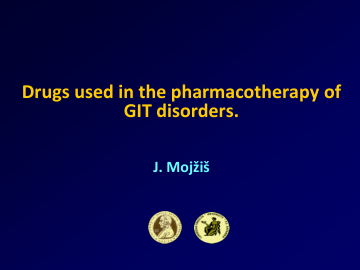
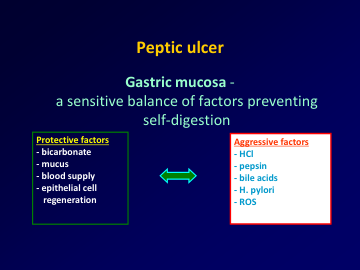
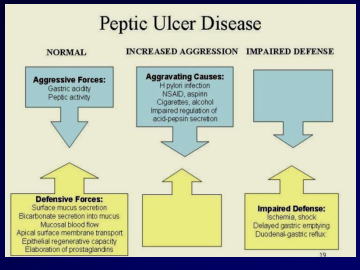
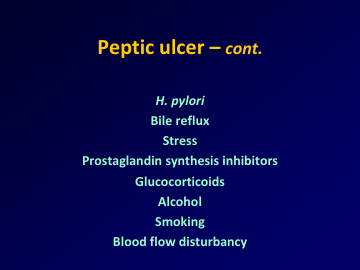
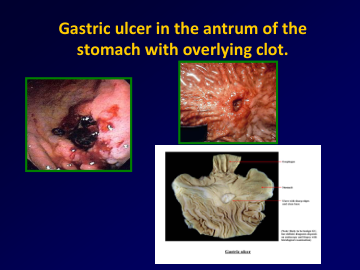
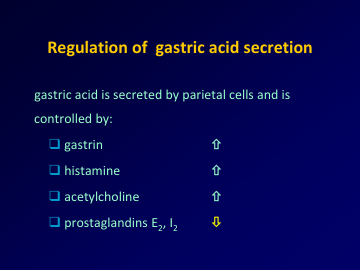
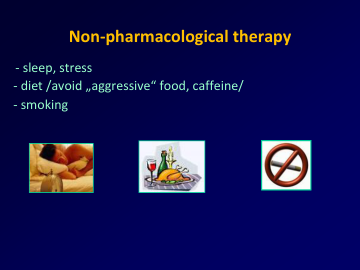
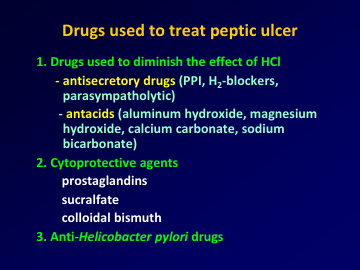
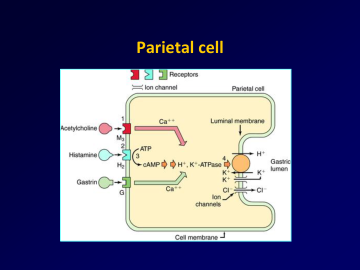
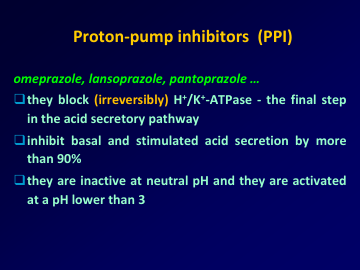
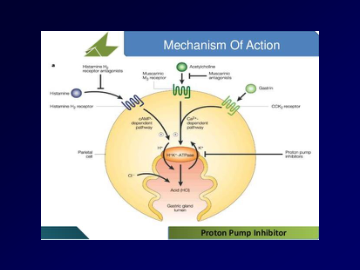
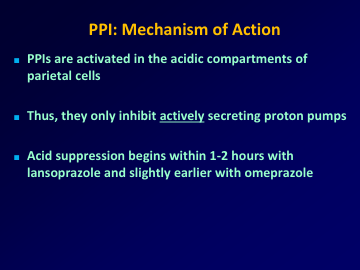
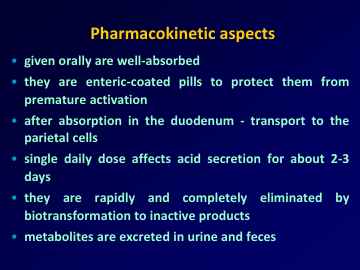
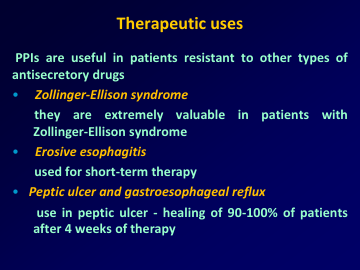
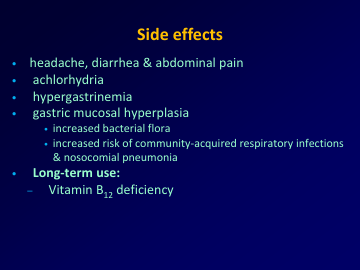
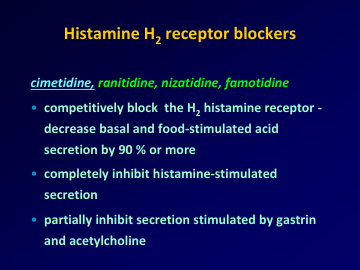
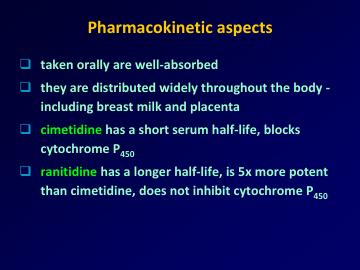
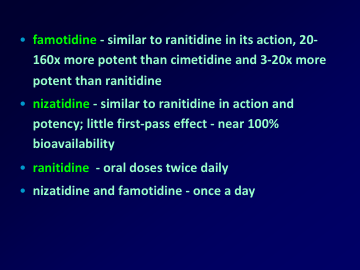
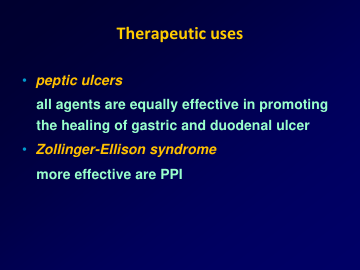
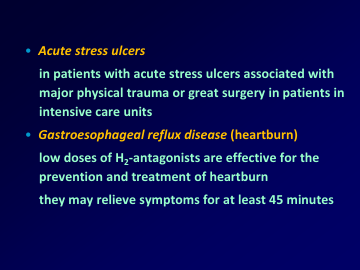
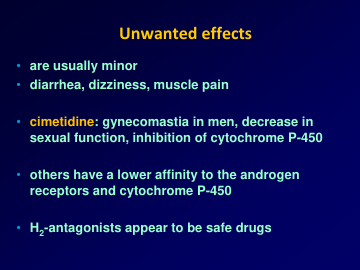
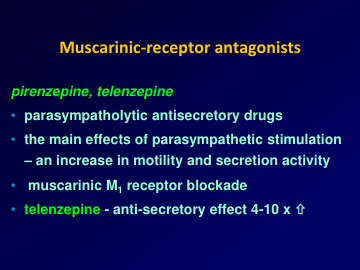
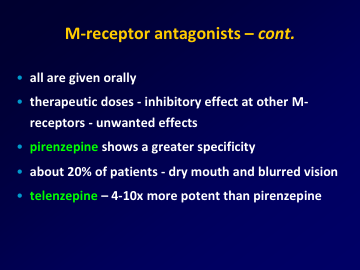
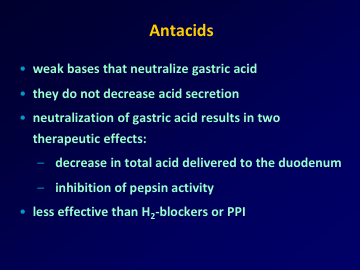
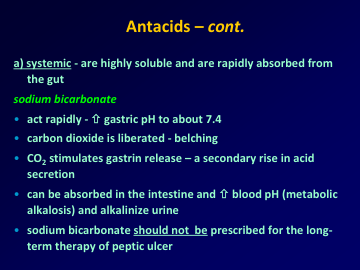
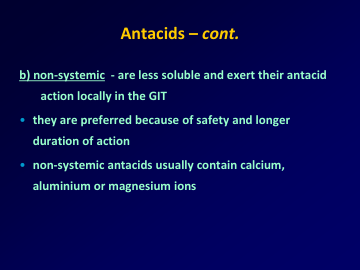
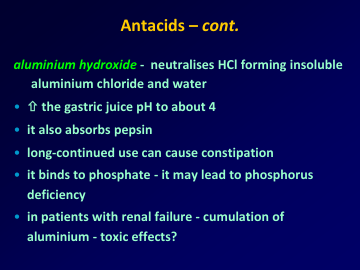
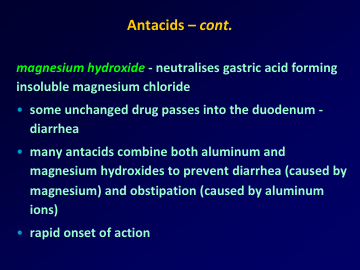
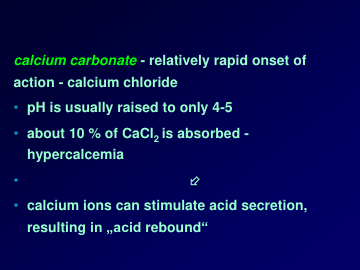
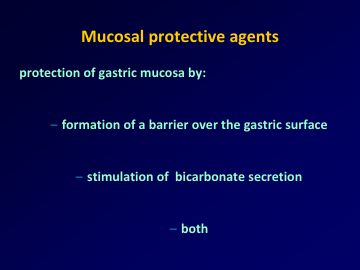
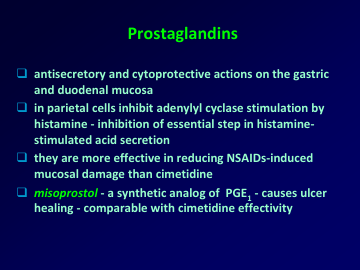
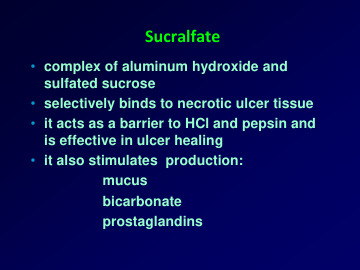
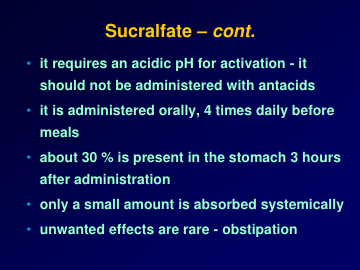
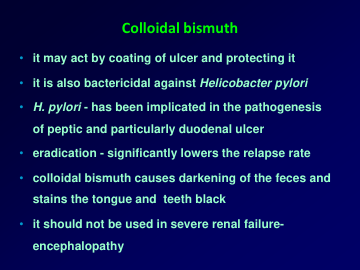
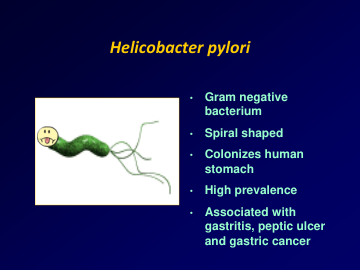
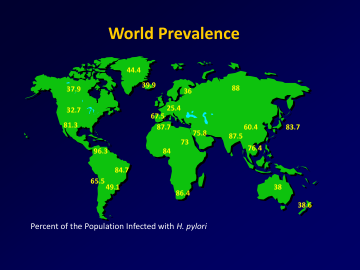
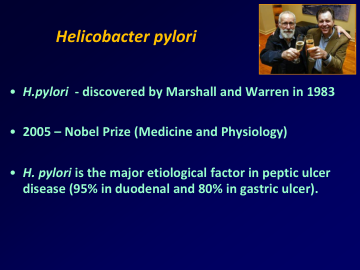
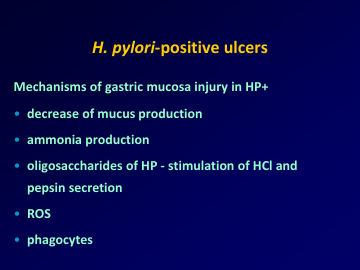
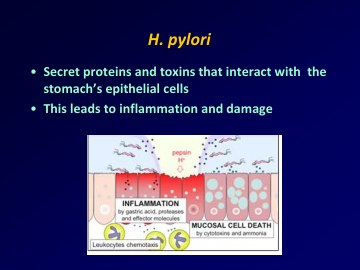
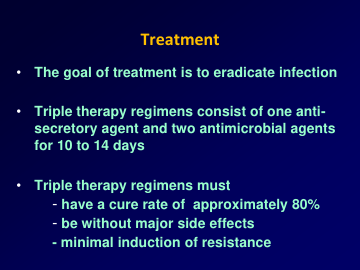
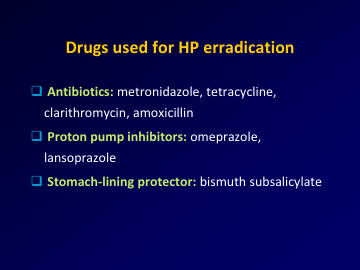
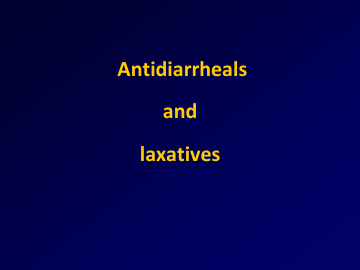
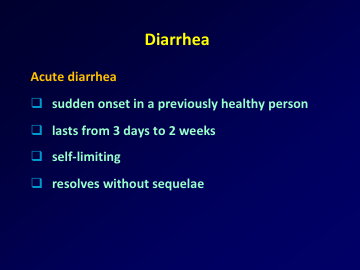
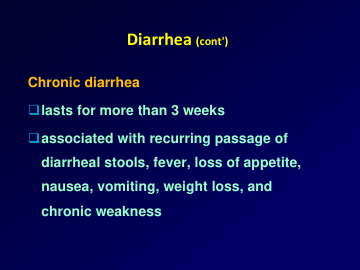
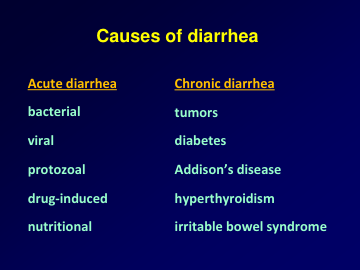
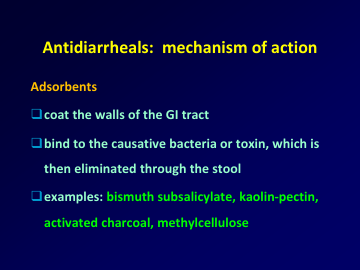
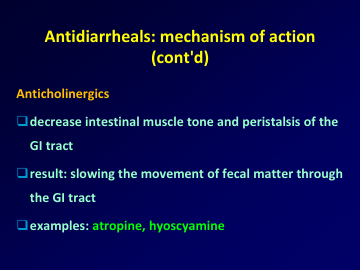
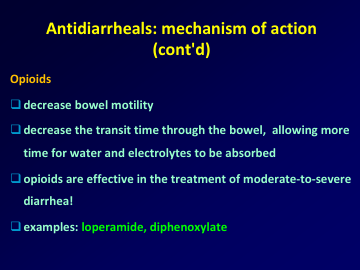
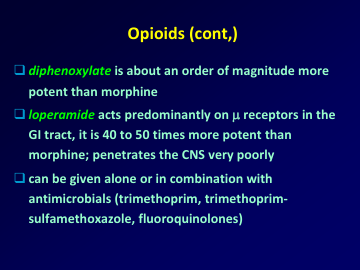
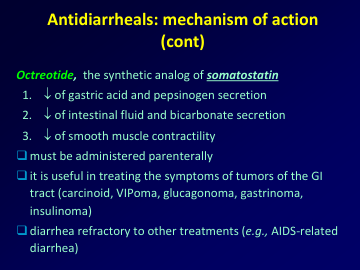
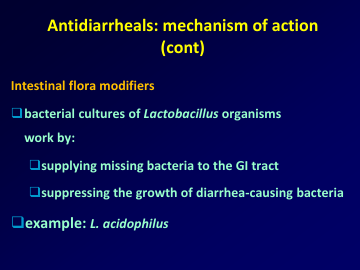
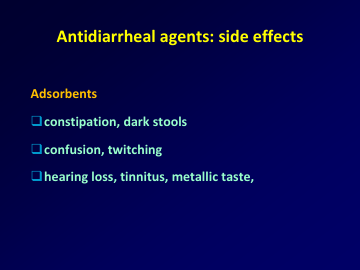
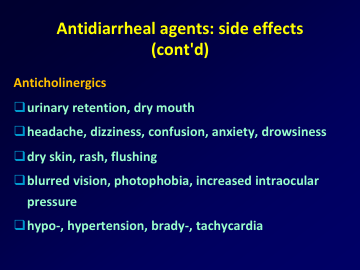
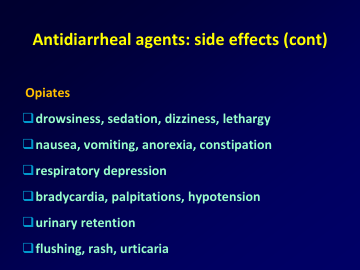
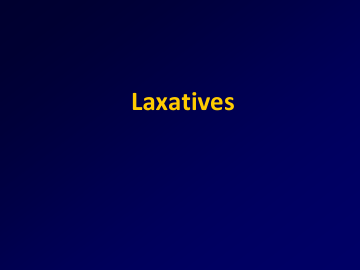
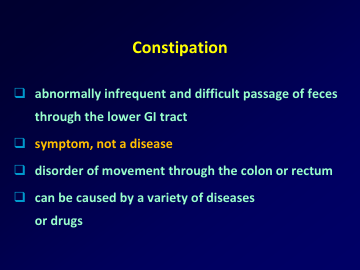
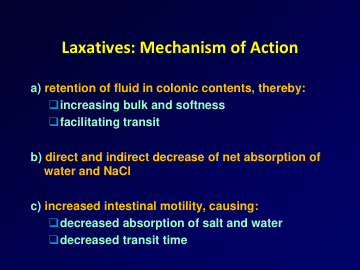
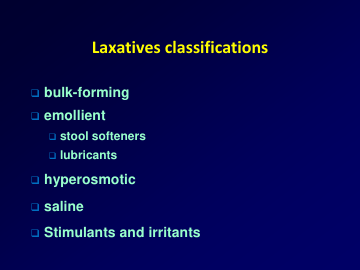
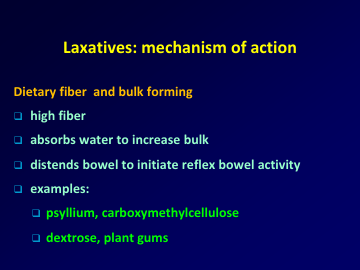
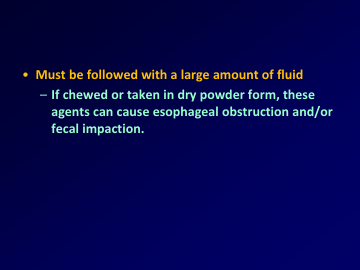
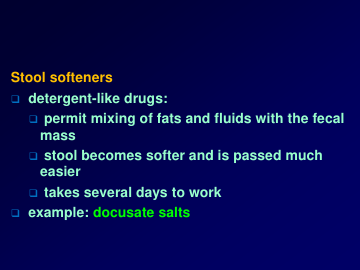
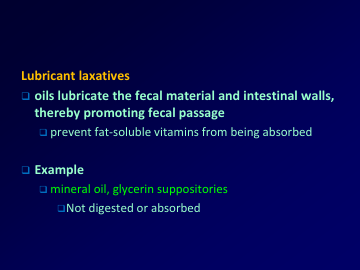
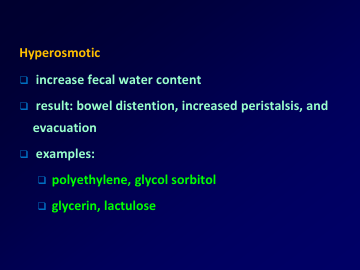
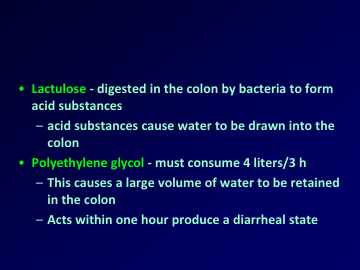
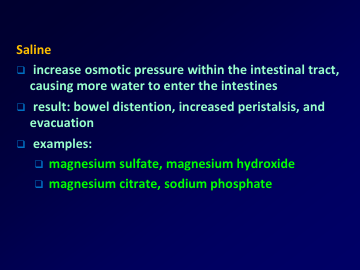
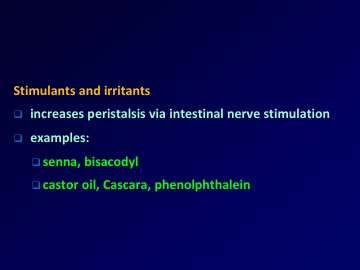
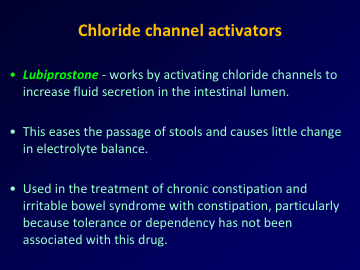
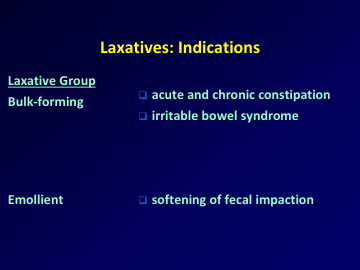
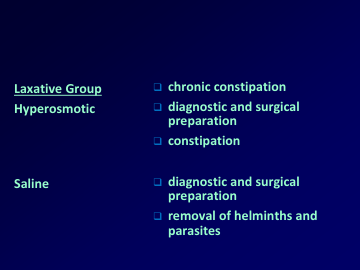
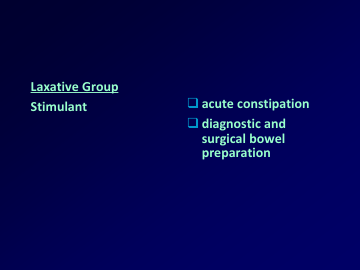
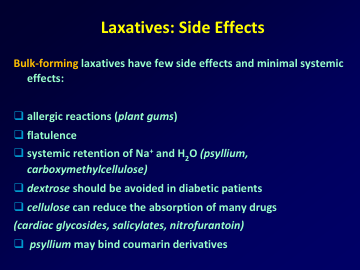
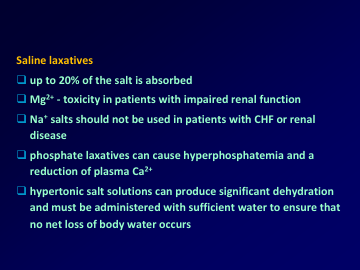
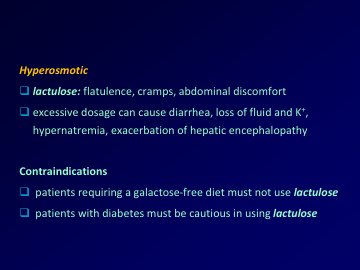
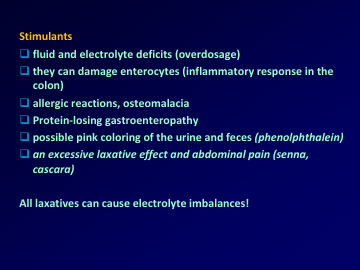
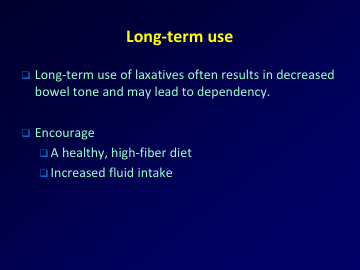
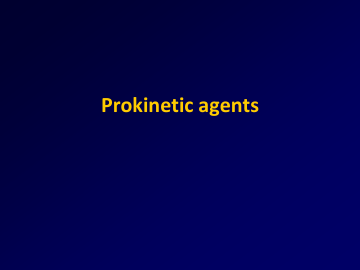
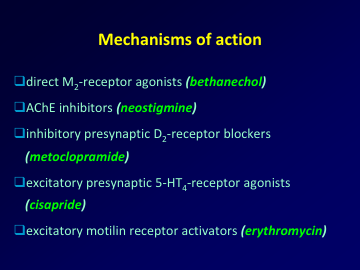
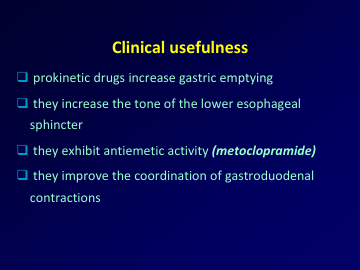
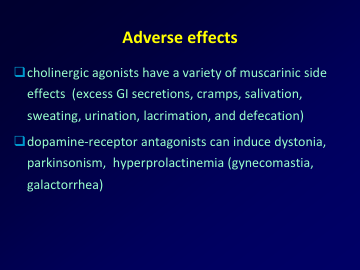

In [4]:
import os
import glob
import fitz  # PyMuPDF
import pandas as pd
from PIL import Image
import io
import base64
from IPython.display import display, HTML
import ftfy  # Fix text for you
import unidecode  # Normalize unicode to ASCII

class PresentationLoader:
    def __init__(self, materials_folder):
        self.materials_folder = materials_folder
        self.pdf_file = self.get_latest_pdf()
        self.images = []
        self.texts = []
        self.df = None
        
    def get_latest_pdf(self):
        """Get the latest PDF file from the materials folder."""
        list_of_files = glob.glob(os.path.join(self.materials_folder, '*.pdf'))
        if not list_of_files:
            raise FileNotFoundError("No PDF files found in the materials folder.")
        latest_file = max(list_of_files, key=os.path.getctime)
        return latest_file
    
    def load_pdf(self):
        """Load the PDF, extract the images and text for each page."""
        doc = fitz.open(self.pdf_file)
        
        # Extract text and images from each page
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text = page.get_text("text")
            
            # Clean up the text
            cleaned_text = self.clean_text(text)
            self.texts.append(cleaned_text)
            
            # Convert page to image and scale it
            pix = page.get_pixmap(matrix=fitz.Matrix(0.5, 0.5))
            
            # Convert to PIL Image and store in memory
            img = Image.open(io.BytesIO(pix.tobytes()))
            
            # Convert image to base64 for embedding in HTML DataFrame
            buffer = io.BytesIO()
            img.save(buffer, format="PNG")
            img_str = base64.b64encode(buffer.getvalue()).decode()
            
            # Display the scaled-up image
            img_html = f'<img src="data:image/png;base64,{img_str}"/>'
            self.images.append(img_html)
            
    def clean_text(self, text):
        """Clean up the text by normalizing and fixing strange characters."""
        # Fix text encoding issues
        text = ftfy.fix_text(text)
        
        # Convert strange Unicode characters to plain ASCII if possible
        text = unidecode.unidecode(text)
        
        # Don't replace \n with spaces, we preserve newlines
        # Ensure newline characters are preserved properly
        text = text.replace('\\n', '\n')  # Just in case it's escaped
        
        return text
    
    def create_dataframe(self):
        """Create a DataFrame with index, image, and text."""
        data = []
        for i, (image, text) in enumerate(zip(self.images, self.texts)):
            data.append({
                'Index': i+1,
                'Slide Image': image,
                'Extracted Text': text.replace('\n', '<br>')  # For HTML display, use <br> for newlines
            })
            
        self.df = pd.DataFrame(data)
        
    def display_slides(self):
        """Display the DataFrame with images and texts."""
        # Set pandas options to display all text without truncation
        pd.set_option('display.max_colwidth', None)
        pd.set_option('display.max_rows', None)
        
        # Render DataFrame as HTML with images embedded and newlines preserved
        display(HTML(self.df.to_html(escape=False).replace("\\n", "<br>")))

# Usage
materials_folder = './materials'  # Replace with the path to your materials folder
loader = PresentationLoader(materials_folder)

# Load the PDF and process
loader.load_pdf()

# Create the DataFrame
loader.create_dataframe()

# Display the slides with images and text in the DataFrame
loader.display_slides()